# CLMM Triaxiality - From Quadrupole Shears to Mass and Ellipticity
### This example showcases fitting a Mock Catalog

In [1]:
# Import Python Modules

#CLMM:
import clmm
from clmm import Cosmology
from clmm.dataops import _compute_tangential_shear, _compute_4theta_shear, make_radial_profile

#General:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

#MCMC:
from tqdm import tqdm
import time as pytime
import h5py 
import corner
import emcee
from multiprocessing import Pool

#Fiducial Cosmology:
cosmo = Cosmology(H0=70.0, Omega_dm0=0.2248, Omega_b0=0.3 - 0.2248, Omega_k0=0.0)

## Load Mock Catalog 

We have used an elliptical NFW model to generate a mock catalog with weak lensing shears.

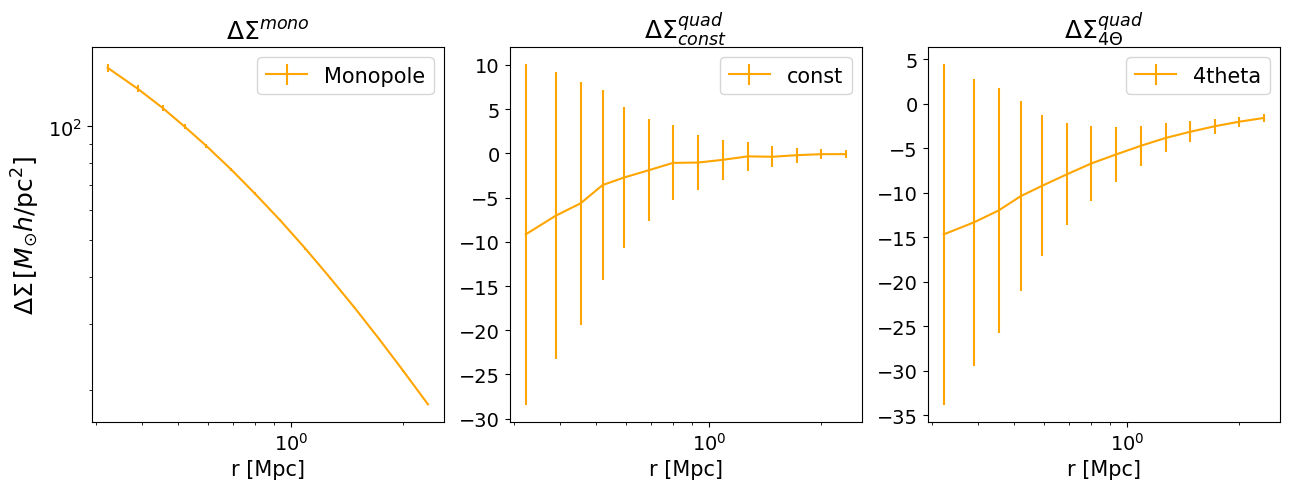

In [4]:
#Loading mock catalog:
q_true=0.7
dir_loc_mcmc = "Elliptical_lenses_data/catalog_horizontal_rescale_q"+str(q_true)+"/"
f=dir_loc_mcmc + "MCMC"

z_cluster=0.47
z_source=0.8
sigma_crit = cosmo.eval_sigma_crit(z_cluster,z_source)

gamma1 = np.load(dir_loc_mcmc+"gamma1.npy").flatten()
gamma2 = np.load(dir_loc_mcmc+"gamma2.npy").flatten()
x_arcsec = np.load(dir_loc_mcmc+"x_arcsec.npy").flatten()
y_arcsec = np.load(dir_loc_mcmc+"y_arcsec.npy").flatten()
r = np.sqrt((x_arcsec**2 + y_arcsec**2))                 #In arcsecs
r_rad = r*np.pi/180.0 * 1/3600                           #In radians
theta = np.arctan2(y_arcsec, x_arcsec)                   #In radians

# Computing the Monopole and Quadrupole lensing profiles using in-built CLMM functions:
DSmono = _compute_tangential_shear(gamma1, gamma2, theta)*sigma_crit
DS4theta = _compute_4theta_shear(gamma1, gamma2, theta)*sigma_crit
DSconst = gamma1*sigma_crit


# Binning the Monopole and Quadrupole profiles using CLMM wrapper:
N_bins=15
r_min = 0.3
r_max = 2.5
bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), N_bins)                       
binned_profile = make_radial_profile([DSmono,DS4theta,DSconst],angsep=r_rad,angsep_units='radians',bin_units='Mpc', bins=bin_edges, 
                                     error_model='std',cosmo=cosmo,z_lens=z_cluster)
#Monopole Bins:
r_mono = binned_profile['radius']
r_quad = binned_profile['radius']

ds_mono = binned_profile['p_0']
ds_mono_err = binned_profile['p_0_err']/np.sqrt(binned_profile['n_src'])
ds_quad_4theta = binned_profile['p_1']
ds_quad_4theta_err = binned_profile['p_1_err']/np.sqrt(binned_profile['n_src'])
ds_quad_const = binned_profile['p_2']
ds_quad_const_err = binned_profile['p_2_err']/np.sqrt(binned_profile['n_src'])

global ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad                                                                                                                               

# Visualizing the Profiles:
fig,ax = plt.subplots(1,3, figsize=[13,5])
ax[0].errorbar(r_mono, ds_mono/1E12, yerr=ds_mono_err/1E12, color='orange', label='Monopole')
ax[0].set_ylabel(r'$\Delta\Sigma \,[M_{\odot} h/\rm{pc}^{2}]$', fontsize=15)
ax[0].set_xlabel('r [Mpc]', fontsize=15)
ax[0].loglog()
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[0].set_ylabel(r'$\Delta\Sigma \,[M_{\odot} h/\rm{pc}^{2}]$', fontsize=18)
ax[0].set_title(r'$\Delta\Sigma^{mono}$', fontsize=18)
ax[0].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax[1].errorbar(r_quad, ds_quad_const/1E12, yerr=ds_quad_const_err/1E12, color='orange', label='const')
ax[1].legend(fontsize=15)
ax[1].set_xlabel('r [Mpc]', fontsize=15)
ax[1].set_xscale('log')
ax[1].tick_params(axis='both', which='both', labelsize=14)
ax[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[1].set_title(r'$\Delta\Sigma^{quad}_{const}$', fontsize=18)

ax[2].errorbar(r_quad, ds_quad_4theta/1E12, yerr=ds_quad_4theta_err/1E12, color='orange', label='4theta')
ax[2].set_xscale('log')
ax[2].set_xlabel('r [Mpc]', fontsize=15)
ax[2].tick_params(axis='both', which='both', labelsize=14)
ax[2].set_title(r'$\Delta\Sigma^{quad}_{4\Theta}$', fontsize=18)
ax[2].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[2].legend(fontsize=15)
plt.tight_layout()


## Set up the Prior, Likelihood and Posterior functions

We use a guassian likelihood with flat priors on the Mass, concentration and ellipticity parameter.

In [12]:
def gaussian_log_likelihood(data,error,model):
    '''
    A gaussian log likelihood function.
    
    INPUTS:
        data: array
            Array of data that is described by a guassian likelihood
        error: array
            1-Sigma error on the data point. Should be of the same dimension as data
        model: array
            Model prediction for each data point. Should also be of the same dimension as data
    OUTPUTS:
        result: float
            The log likelihood computed given the model and the data.
    '''
    sigma = error
    term1 = -0.5*np.sum(np.log(2*np.pi*(sigma**2)))
    chi2 = ((data - model)**2 / (sigma)**2)
    term2 = -0.5*np.sum(chi2)
    result = term1+term2
    return result

def priors(params, limits):
    '''
    Computes log priors for each parameter. We use flat priors on all the parameters.
    INPUTS:
        params: array
            A set of parameter values of length ndim.
        limits: array
            Min and Max bounds for the flat prior. The shape should be (2,ndim)
    OUTPUTS:
        prior: float
            The log prior evaluated for the given set of parameter values.
    '''
    a,b,c = params
    if (a < limits[0][0] or a > limits[0][1]):        #mdelta
        return -np.inf
    elif (b < limits[1][0] or b > limits[1][1]):      #cdelta
        return -np.inf
    elif (c < limits[2][0] or c > limits[2][1]):      #ell
        return -np.inf

    else:
        return 0.0
    

def log_posterior(params):
    '''
    Log of posterior calculated by the Bayes rule, a sum of the log of likelihood and log prior.
    INPUTS:
        params: array
            An array of parameter values where the posterior is to be computed.
    OUTPUTS:
        log_posterior: float
            The sum of log likelihood and log prior.
    '''
    mdelta,cdelta,ell = params
    
    #Evaluate the prior:
    prior=priors(params, limits)
    
    #Avoid likelihood evaluation when prior is -infinity:
    if prior == -np.inf:
        lnP = -np.inf
    else:
        #Evaluating the model:
        ds_mono_model = clmm.compute_excess_surface_density_triaxial(r_proj=r_mono, mdelta=mdelta, cdelta=cdelta, ell=ell, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw',
                                                                n_grid=10000, delta_mdef=200, massdef='critical', term='mono')
        ds_quad_4theta_model = clmm.compute_excess_surface_density_triaxial(r_proj=r_quad, mdelta=mdelta, cdelta=cdelta, ell=ell, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw',
                                                                n_grid=10000, delta_mdef=200, massdef='critical', term='quad_4theta')
        ds_quad_const_model = clmm.compute_excess_surface_density_triaxial(r_proj=r_quad, mdelta=mdelta, cdelta=cdelta, ell=ell, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw',
                                                                n_grid=10000, delta_mdef=200, massdef='critical', term='quad_const')
        
        #Evaluating the likelihood:
        lnP = prior 
        lnP += gaussian_log_likelihood(ds_mono, ds_mono_err, ds_mono_model)
        lnP += gaussian_log_likelihood(ds_quad_4theta, ds_quad_4theta_err, ds_quad_4theta_model)
        lnP += gaussian_log_likelihood(ds_quad_const, ds_quad_const_err, ds_quad_const_model)

    # safeguard against NaNs:
    if np.isnan(lnP):
        return -np.inf
    else:
        return lnP
    

## Defining a wrapper for MCMC sampling with emcee and fitting the data:

In [13]:
def emcee_wrapper(params_key, limits, true_value,
                 ndim, nwalkers, nsteps=1000, nburn=350, filename=None):  
    '''
    A wrapper for the emcee function, a corner plot and a chain plot.
    INPUTS:
        params_key: array of length ndim
            List of parameter names. Should be of length ndim.
        limits: array
            Min and Max values for a flat prior for each parameter. Its of the shape (2, ndim)
        true_value: array of length ndim
            Truth for each free parameter
        ndim: float
            Number of free parameters in the model
        nwalkers:
            Number of MCMC walkers/chains
        nsteps: float, optional
            Number of steps to be traversed by each MCMC walker
        nburn: float, optional
            Number of initial steps per walker to be burned or removed. 
        filename: string
            Location and name of the file where the walkers are to be stored.
    OUTPUTS:
        post: array
            Walkers post-burn
        mean: array
            Mean for each parameter
        err_plus: array
            1-sigma error on each parameter above the mean
        err_minus: array
            1-sigma error on each parameter below the mean
    '''
    
    starting_guess_t=[]
    for i in np.arange(len(params_key)):
        guess=[]
        for j in np.arange(nwalkers):
            guess.append((limits[i][1]-limits[i][0])*np.random.random()+limits[i][0])
        starting_guess_t.append(guess)
    starting_guesses=np.column_stack(starting_guess_t)
    print('Starting guesses for ',nwalkers,' chains:')
    print(starting_guesses)
            
    start=pytime.time()
    if filename!=None:
        ## STORING THE CHAINS TO FILE
        backend = emcee.backends.HDFBackend(filename[:-4]+'.h5')
        backend.reset(nwalkers, ndim) ## Comment this line out to append steps to a previous run stored in the file
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=None,
                                             vectorize=False, backend=backend, pool=pool)
            pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)
            
    if filename==None:   
        ## RETURNING THE CHAINS WITHOUT STORING TO FILE
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[gamma1, gamma2, x_arcsec, y_arcsec],
                                             vectorize=False, pool=pool)
            pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

    end=pytime.time()
    print("Time taken:{0:.1f} seconds".format(end-start))
            
    post = np.concatenate(sampler.chain[:, nburn: , :])
        
    #Corner plot:

    fig = plt.figure(figsize=[10,10])
    figure = corner.corner(post,labels=params_key, quantiles=[0.16, 0.5, 0.84], 
                           show_titles=True, title_fmt='.2e', fig=fig)
    figure.patch.set_facecolor('white')
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    
    if filename!=None:
        plt.savefig(filename[:-4]+"_corner_plot.png",facecolor="white", dpi="figure", format="png")  
        
    #Chain plot:
    color=iter(cm.rainbow(np.linspace(0,1,nwalkers)))
    
    # set up a plot with two windows, one for each parameter:
    plt.figure(figsize=(10,5))
    for i in range(len(params_key)):
        plt.subplot(100*len(params_key)+10+i+1)
        plt.ylabel(params_key[i], fontsize=10)
    for j in range(nwalkers):
        c=next(color)
        for i in range(len(params_key)):
            plt.subplot(100*len(params_key)+10+i+1)
            plt.plot(sampler.chain[j,nburn:,i], ',', color=c)
            
    if filename!= None:
        plt.savefig(filename[:-4]+"_chain_plot.png",facecolor="white", dpi="figure", format="png")
        
    mean=[]
    err_minus=[]
    err_plus=[]
    for i in range(len(params_key)):
        mean.append(np.quantile((post[:,i].flatten()), 0.5))
        err_minus.append(np.quantile((post[:,i].flatten()), 0.16))
        err_plus.append(np.quantile((post[:,i].flatten()), 0.84))
    mean = np.array(mean)
    err_plus = np.array(err_plus) - mean
    err_minus = mean - np.array(err_minus)

    return post, mean, err_plus, err_minus

Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


100%|██████████| 3000/3000 [05:16<00:00,  9.48it/s]


Time taken:317.3 seconds


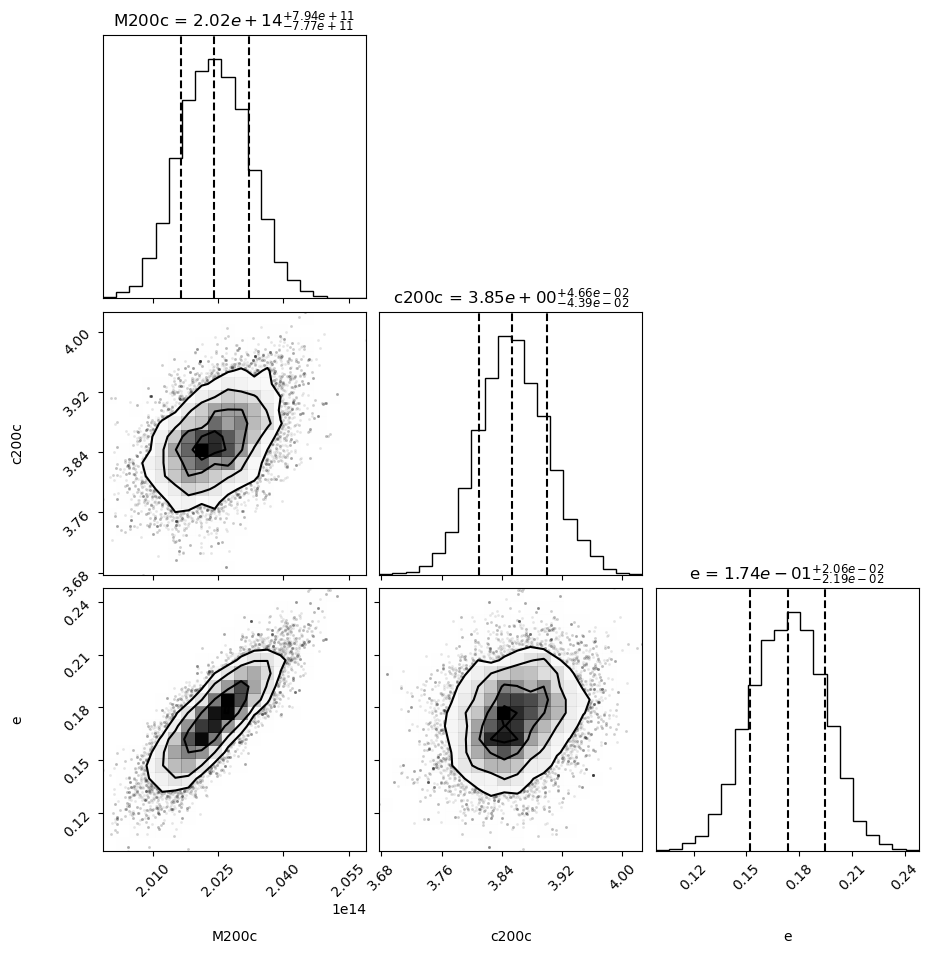

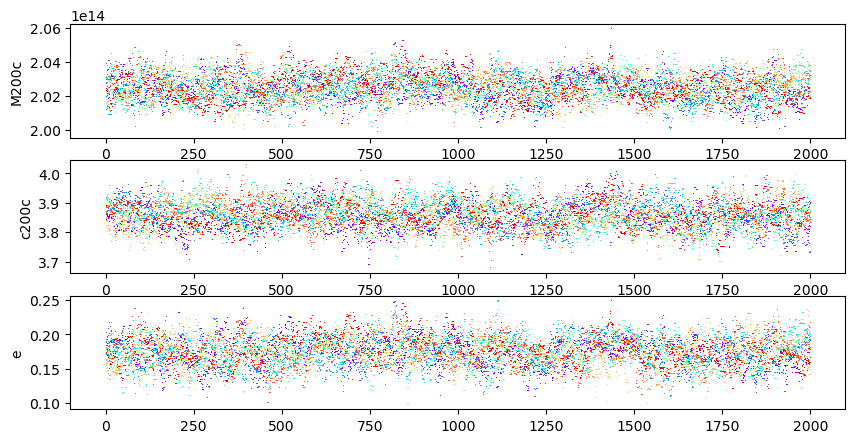

In [14]:
# CALL EMCEE

#MCMC parameters:
params_key=["M200c","c200c","e"]
ndim = len(params_key)
nwalkers = ndim*2+4
nsteps = 3000
nburns = 1000
np.random.seed(0)

limits=[[1.0E12,5.0E14],  # mdelta
       [0.0,20.0],     # cdelta
       [0.0001,0.99]]   # e

z_cl=0.47
z_gal=0.8
ell_true= 1*(1-q_true)/(1+q_true)
true_value=[2.0E14, 3.89055, ell_true]

post, mean, err_plus, err_minus = emcee_wrapper(params_key=params_key,limits=limits,true_value=true_value, ndim=ndim,nwalkers=nwalkers,
                                                nsteps=nsteps, nburn=nburns, filename=f)


## Fit results

We can check the monopole and quadrupole simultaneous fits by overplotting it on the data-points. The shaded regions represent 1-$\sigma$ uncertainty on the fit.

mdelta_fit= 201077345290408.97 cdelta_fit= 3.8314249882920413 ell_fit =  0.1762525289115617
Computed and Plotted 1-sigma intervals for Mono...
Computed and Plotted 1-sigma intervals for Const...
Computed and Plotted 1-sigma intervals for 4theta...


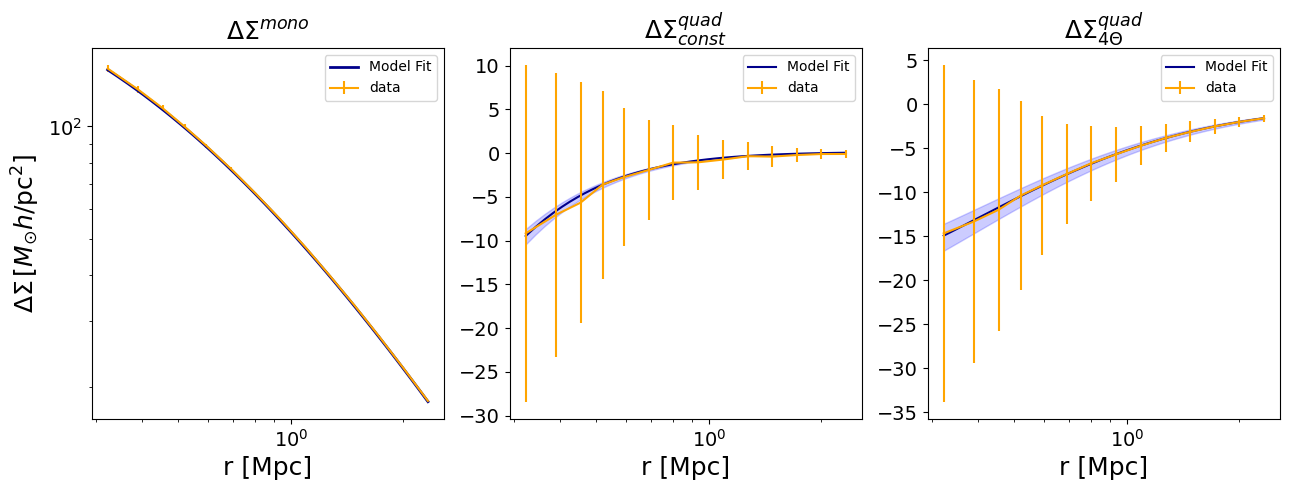

In [15]:
mdef = 'critical'
reader = emcee.backends.HDFBackend(f)
nburns=500
post = reader.get_chain(discard=nburns, flat=True)

mean=[]
err_minus=[]
err_plus=[]
for i in range(len(params_key)):
    mean.append(np.quantile((post[:,i].flatten()), 0.5))
    err_minus.append(np.quantile((post[:,i].flatten()), 0.16))
    err_plus.append(np.quantile((post[:,i].flatten()), 0.84))
mean = np.array(mean)
err_plus = np.array(err_plus) - mean
err_minus = mean - np.array(err_minus)

mdelta_fit = mean[0]
cdelta_fit = mean[1]
ell_fit = mean[2]
print("mdelta_fit=",mdelta_fit,"cdelta_fit=",cdelta_fit, "ell_fit = ",ell_fit)
cosmo = Cosmology(H0=70.0, Omega_dm0=0.2248, Omega_b0=0.3 - 0.2248, Omega_k0=0.0)

fig,ax = plt.subplots(1,3, figsize=[13,5])
ax[0].errorbar(r_mono, ds_mono/1E12, yerr=np.abs(ds_mono_err)/1E12, label='data', color='orange')
r=np.linspace(np.min(r_mono), np.max(r_mono), 100)
ds_model = clmm.compute_excess_surface_density_triaxial(ell=ell_fit, r_proj=r, mdelta=mdelta_fit, cdelta=cdelta_fit, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             n_grid=10000, delta_mdef=200, massdef=mdef, term='mono')

ax[0].plot(r, ds_model/1E12, label='Model Fit', color='darkblue', lw=2)
ax[0].set_xlabel('r [Mpc]', fontsize=18)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_title(r'$\Delta\Sigma^{mono}$', fontsize=18)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[0].set_ylabel(r'$\Delta\Sigma \,[M_{\odot} h/\rm{pc}^{2}]$', fontsize=18)
ax[0].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[0].legend()
#plt.xlim([1.75,2.25])


r=np.linspace(np.min(r_quad), np.max(r_quad), 100)
ds_model = clmm.compute_excess_surface_density_triaxial(ell=ell_fit, r_proj=r, mdelta=mdelta_fit, cdelta=cdelta_fit, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             n_grid=10000, delta_mdef=200, massdef=mdef, term='quad_const')
ax[1].plot(r, ds_model/1E12, label='Model Fit', color='darkblue')
ax[1].errorbar(r_quad, ds_quad_const/1E12,  yerr=ds_quad_const_err/1E12, label='data', color='orange')
ax[1].set_yscale('linear')
ax[1].set_xscale('log')
ax[1].set_title(r'$\Delta\Sigma^{quad}_{const}$', fontsize=18)
ax[1].set_xlabel('r [Mpc]', fontsize=18)
ax[1].tick_params(axis='both', which='both', labelsize=14)
ax[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[1].legend()


ds_model = clmm.compute_excess_surface_density_triaxial(ell=ell_fit, r_proj=r, mdelta=mdelta_fit, cdelta=cdelta_fit, z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                             n_grid=10000, delta_mdef=200, massdef=mdef, term='quad_4theta')

ax[2].plot(r, ds_model/1E12, label='Model Fit', color='darkblue')
ax[2].errorbar(r_quad, ds_quad_4theta/1E12,  yerr=ds_quad_4theta_err/1E12, label='data', color='orange')
ax[2].set_yscale('linear')
ax[2].set_xscale('log')
ax[2].set_title(r'$\Delta\Sigma^{quad}_{4\Theta}$', fontsize=18)
ax[2].set_xlabel('r [Mpc]', fontsize=18)
ax[2].tick_params(axis='both', which='both', labelsize=14)
ax[2].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[2].legend()
plt.tight_layout()



plot_confidence_bands = True
if plot_confidence_bands == True:
    post_s=post[0:500]
    ds_model = np.zeros([len(post_s),len(r)])
    for i,p in enumerate(post_s):
        ds_model[i,:] = clmm.compute_excess_surface_density_triaxial(ell=p[2], r_proj=r, mdelta=p[0], cdelta=p[1], z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                                 n_grid=10000, delta_mdef=200, massdef=mdef, term='mono')
    model_minus = np.zeros(len(r))
    model_plus = np.zeros(len(r))
    for i,r_i in enumerate(r):
        model_minus[i] = np.quantile(ds_model[:,i],0.16)
        model_plus[i] = np.quantile(ds_model[:,i],0.84)
    ax[0].fill_between(r, model_minus/1E12, model_plus/1E12, color='blue', alpha=0.2)
    print('Computed and Plotted 1-sigma intervals for Mono...')
    

    ds_model = np.zeros([len(post_s),len(r)])
    for i,p in enumerate(post_s):
        ds_model[i,:] = clmm.compute_excess_surface_density_triaxial(ell=p[2], r_proj=r, mdelta=p[0], cdelta=p[1], z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                                 n_grid=10000, delta_mdef=200, massdef=mdef, term='quad_const')
    model_minus = np.zeros(len(r))
    model_plus = np.zeros(len(r))
    for i,r_i in enumerate(r):
        model_minus[i] = np.quantile(ds_model[:,i],0.16)
        model_plus[i] = np.quantile(ds_model[:,i],0.84)
    ax[1].fill_between(r, model_minus/1E12, model_plus/1E12, color='blue', alpha=0.2)
    print('Computed and Plotted 1-sigma intervals for Const...')
    

    ds_model = np.zeros([len(post_s),len(r)])
    for i,p in enumerate(post_s):
        ds_model[i,:] = clmm.compute_excess_surface_density_triaxial(ell=p[2], r_proj=r, mdelta=p[0], cdelta=p[1], z_cl=z_cl, cosmo=cosmo, halo_profile_model='nfw', 
                                                 n_grid=10000, delta_mdef=200, massdef=mdef, term='quad_4theta')
    model_minus = np.zeros(len(r))
    model_plus = np.zeros(len(r))
    for i,r_i in enumerate(r):
        model_minus[i] = np.quantile(ds_model[:,i],0.16)
        model_plus[i] = np.quantile(ds_model[:,i],0.84)
    ax[2].fill_between(r, model_minus/1E12, model_plus/1E12, color='blue', alpha=0.2)
    print('Computed and Plotted 1-sigma intervals for 4theta...')